In [ ]:
import os
import numpy as np
import pandas as pd
import scipy
import ta as ta
import yfinance as yf
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import LSTM, Dense, Dropout, RepeatVector,Flatten,TimeDistributed,Reshape
from keras.layers.convolutional import Conv1D,MaxPooling1D,Conv2D,MaxPooling2D
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
from ta import add_all_ta_features
from ta.utils import dropna
from tsmoothie.smoother import *
from tsmoothie.utils_func import sim_randomwalk

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from datetime import date, timedelta
from pickle import dump,load



def CriaDiretorios(raiz_path,ativo,tipo_treinamento):
    
    Modelos_CNN = "RedesNeurais_CNN/"
    
    if os.path.exists(Modelos_CNN)==False:
        os.mkdir(Modelos_CNN)
        
    raiz_path = Modelos_CNN + raiz_path
    
    if os.path.exists(raiz_path)==False:
        os.mkdir(raiz_path)

    Raiz_ativo = raiz_path+"/"+ativo
    
    if os.path.exists(Raiz_ativo)==False:
        os.mkdir(Raiz_ativo)

    return Raiz_ativo+"/"


def preparar_dados_financeiros(ticker,pulo,start="",end="",remove_out=False):

    print(ticker)
    
    if start == "" or end=="":
        base = yf.download(ticker)
        
    elif start !="" and end != "":
        base = yf.download(ticker,start=start,end=end)
        
        
    if base["Open"].tail(1)[0] == 0:
        base = base[:len(base)-1]

    if pulo != 0 and pulo != 1:
        
        base = ReduzirRuido(base,pulo)

    if remove_out:
        return remover_outliers(base)
    else:
        return base
    
    
def preparar_dados_financeiros_porAnos(ticker,pulo,anos_anteriores=4,remove_out=False):

    print(ticker)
    data_atual = date.today()
    data_inicial = (data_atual - timedelta(days=anos_anteriores * 365)).strftime("%Y-%m-%d")
    
    base = yf.download(ticker,start=data_inicial,end=data_atual.strftime("%Y-%m-%d"))
        
    if base["Open"].tail(1)[0] == 0:
        base = base[:len(base)-1]

    if pulo != 0 and pulo != 1:
        
        base = ReduzirRuido(base,pulo)

    if remove_out:
        return remover_outliers(base)
    else:
        return base


def remover_outliers(base):

    z_scores = scipy.stats.zscore(base)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    new_base = base[filtered_entries]

    return new_base


def ReduzirRuido(base,pulo=5):
    
    de = 0
    ate = pulo
    
    df = base.tail(len(base)-(len(base)%pulo))

    df = df.reset_index()

    lista_diario = list()
    
    for i in range(int(len(df)/pulo)):

        lista_diario.append(df[de:ate])

        de += pulo
        ate += pulo
    
    
    abertura = list()
    fechamento = list()
    maximo = list()
    minimo = list()
    datas = list()

    i = 0
    for triario in lista_diario:

        datas.append(triario["Date"][i])
        abertura.append(triario["Open"][i])
        fechamento.append(triario["Close"][i+(pulo-1)])
        maximo.append(triario["High"].max())
        minimo.append(triario["Low"].min())

        i+=pulo
        
        
    triario = zip(datas,abertura,fechamento,minimo,maximo)
    
    triario_df = pd.DataFrame(triario,columns=["Date","Open","Close","Low","High"])
    
    triario_df = triario_df.set_index("Date")

    return triario_df


def GetTsi(base, gaussian_knots, gaussian_sigma):

    tsi_config = [25, 13]

    resultados_tsi = ta.momentum.TSIIndicator(
        base["Close"], tsi_config[0], tsi_config[1], False)

    tsi_df = pd.DataFrame(resultados_tsi.tsi())

    tsi_df.dropna(inplace=True)
    
    tsi_np = tsi_df["tsi"].to_numpy()
    tsi_np.reshape(1, len(tsi_np))

    smoother = GaussianSmoother(n_knots=gaussian_knots, sigma=gaussian_sigma)
    smoother.smooth(tsi_np)

    tsi_df["gaussian"] = smoother.smooth_data[0]
    
    return tsi_df


def preparar_dados_para_treinamento(anteriores, base_treinamento_normalizada):

    previsores = []
    preco_real = []

    for i in range(anteriores, len(base_treinamento_normalizada)):

        previsores.append(base_treinamento_normalizada[i-anteriores:i, 0])
        preco_real.append(base_treinamento_normalizada[i, 0])

    previsores, preco_real = np.array(previsores), np.array(preco_real)
    previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

    return previsores, preco_real


def Normalizar(base, coluna):

    normalizador = MinMaxScaler(feature_range=(0, 1))

    if coluna == "tsi":
        Oscilador_treinamento = Oscbaseilador.iloc[:, 0:1].values

    if coluna == "gaussian":
        Oscilador_treinamento = base.iloc[:, 1:2].values


    Oscilador_normalizado = normalizador.fit_transform(Oscilador_treinamento)

    return Oscilador_normalizado, normalizador


def Realizar_previsoes(quantidade_de_previsoes,base,modelo,normalizador,coluna):
    
    #Verifica automaticamente quantos dias anteriores o modelo utiliza
    config = modelo.get_config()
    configuracao = config["layers"][0]["config"]["batch_input_shape"]
    
    anteriores=configuracao[1]
    #--------------------------------------------------------------
    
    #Pega os ultimos n registros da base
    
    if coluna == "ewm":
        entradas = base["ewm"].tail(anteriores).values
        
    if coluna == "gaussian":
        
        entradas = base["gaussian"].tail(anteriores).values
        
    entradas_ = entradas.reshape(-1,1)
    entradas_ = normalizador.transform(entradas_)

    i=0
    while i < quantidade_de_previsoes:

        X_teste = []

        X_teste.append(entradas_[-anteriores:])

        X_teste = np.array(X_teste)
        X_teste = np.reshape(X_teste,(X_teste.shape[0],X_teste.shape[1],1))

        previsao = modelo.predict(X_teste)
        previsao = normalizador.inverse_transform(previsao)    

        entradas = np.append(entradas,previsao)

        entradas_ = entradas.reshape(-1,1)

        entradas_ = normalizador.transform(entradas_)

        i+=1

    return entradas[-quantidade_de_previsoes:]


def Carregar_modelo(modelo):
    
    modelo = keras.models.load_model(modelo,compile=False)
    modelo.compile()
    return modelo

def Carregar_escalonador(scaler):
    scaler = load(open(scaler, 'rb'))
    return scaler


def Get_modelos(ticker,tipo_treinamento):
    
    Modelos_CNN = "RedesNeurais_CNN/"
    Modelos = Modelos_CNN + "Modelos"
    Ticker_Modelos = Modelos+"/"+ticker
    modelos = []
    
    if os.path.exists(Ticker_Modelos):

        for model in os.listdir(Ticker_Modelos):

            if model.endswith(".h5"):
                
                if tipo_treinamento in model:
                    
                    modelos.append(Carregar_modelo(Ticker_Modelos+"/"+model))
                    
        return modelos

    else:
        print("Nao existem modelos para esse ativo")
        return []

    
def Get_Scaler(ticker,tipo_treinamento):
    
    Modelos_CNN = "RedesNeurais_CNN/"
    Scallers  = Modelos_CNN + "Scaller"
    Ticker_Scaller = Scallers+"/"+ticker
    
    if os.path.exists(Ticker_Scaller):

        for scaler in os.listdir(Ticker_Scaller):

            if scaler.endswith(".pkl"):

                if tipo_treinamento in scaler:
                    
                    return [Carregar_escalonador(Ticker_Scaller+"/"+scaler)]

        return []
    else:
        print("Nao existe escalonadores para esse ativo")
        return []


def Realizar_previsoes(quantidade_de_previsoes,base,modelo,normalizador,coluna):
    
    
    #Verifica automaticamente quantos dias anteriores o modelo utiliza
    config = modelo.get_config()
    configuracao = config["layers"][0]["config"]["batch_input_shape"]
    
    anteriores=configuracao[1]
    #--------------------------------------------------------------
    
    #Pega os ultimos n registros da base
            
    if coluna == "gaussian":
        
        entradas = base["gaussian"].tail(anteriores).values
        
    entradas_ = entradas.reshape(-1,1)
    entradas_ = normalizador.transform(entradas_)

    i=0
    while i < quantidade_de_previsoes:

        X_teste = []

        X_teste.append(entradas_[-anteriores:])

        X_teste = np.array(X_teste)
        X_teste = np.reshape(X_teste,(X_teste.shape[0],X_teste.shape[1],1))

        previsao = modelo.predict(X_teste)
        previsao = normalizador.inverse_transform(previsao)    

        entradas = np.append(entradas,previsao)

        entradas_ = entradas.reshape(-1,1)

        entradas_ = normalizador.transform(entradas_)

        i+=1

    return entradas[-quantidade_de_previsoes:]


#ESTRUTURAS DOS MODELOS CNN
def Convolutional_01(ticker,filepath_model,base_normalizada):
    
    anteriores= 45
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))  
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN01.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_02(ticker,filepath_model,base_normalizada):
    
    anteriores= 45
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))  
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN02.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_03(ticker,filepath_model,base_normalizada):
    
    anteriores= 45
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))   
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN03.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_04(ticker,filepath_model,base_normalizada):
    
    anteriores= 60
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))   
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN04.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_05(ticker,filepath_model,base_normalizada):
    
    anteriores= 60
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))   
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN05.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_06(ticker,filepath_model,base_normalizada):
    
    anteriores= 60
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))   
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN06.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_07(ticker,filepath_model,base_normalizada):
    
    anteriores= 90
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)

    model = Sequential()
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN07.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model
    
    
def Convolutional_08(ticker,filepath_model,base_normalizada):
    
    anteriores= 90
    
    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)
    
    model = Sequential()
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN08.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model
    
    
def Convolutional_09(ticker,filepath_model,base_normalizada):
    
    anteriores= 90

    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)    

    model = Sequential()
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN09.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_10(ticker,filepath_model,base_normalizada):
    
    anteriores= 160

    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)    

    model = Sequential()
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN10.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_11(ticker,filepath_model,base_normalizada):
    
    anteriores= 160

    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)    

    model = Sequential()
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN11.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_12(ticker,filepath_model,base_normalizada):
    
    anteriores= 160

    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)    

    model = Sequential()
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN12.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_ALTO_PROCESSAMENTO_01(ticker,filepath_model,base_normalizada):
    
    anteriores= 90

    previsores,resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)    

    model = Sequential()

    #NORMALIZATION PART
    model.add(keras.layers.BatchNormalization())
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN12.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Convolutional_ALTO_PROCESSAMENTO_02(ticker,filepath_model,base_normalizada):
    
    anteriores= 60

    previsores, resultados = preparar_dados_para_treinamento(anteriores, base_normalizada)    

    model = Sequential()

    #NORMALIZATION PART
    model.add(keras.layers.BatchNormalization())
    
    #CONVOLUTIONAL PART
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu', input_shape=(anteriores, 1)))
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())

    #LAYERS PART
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    #CALLBACKS PART
    es = EarlyStopping(monitor="loss", min_delta=1e-15,patience=20, verbose=2)
    
    mcp = ModelCheckpoint(filepath=filepath_model+"_"+ticker.split(".")[0]+'_CNN12.h5', monitor="loss",save_best_only=True, verbose=0)
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(previsores, resultados, epochs=200,batch_size=32, callbacks=[es,mcp], verbose=2)
    
    return model


def Criar_redes_convolucionais(ticker,filepath_scaller,filepath_model,pulo,data_inicial,data_final,g_knots=80,g_sigma=0.0009):
       
    if pulo <= 4:
        
        tipo_treinamento = Retorna_tipoTreinamento(pulo)
        
        filepath_scaller= filepath_scaller + tipo_treinamento
        filepath_model = filepath_model + tipo_treinamento
        
        ticker_sem_sa = ticker.split(".")[0]
        
        ativo_df = preparar_dados_financeiros(ticker,pulo,start=data_inicial,end=data_final,remove_out=False)
         
        tsi_df= GetTsi(ativo_df,g_knots,g_sigma)

        base_normalizada,scaler = Normalizar(tsi_df, "gaussian")
        
        #SALVA ESCALONADOR
        dump(scaler, open(filepath_scaller+"_"+ticker_sem_sa+'_scaller.pkl', 'wb'))

        #Convolutional_01(ticker,filepath_model,base_normalizada)
        #Convolutional_02(ticker,filepath_model,base_normalizada)
        #Convolutional_03(ticker,filepath_model,base_normalizada)
        #Convolutional_04(ticker,filepath_model,base_normalizada)
        #Convolutional_05(ticker,filepath_model,base_normalizada)
        #Convolutional_06(ticker,filepath_model,base_normalizada)
        #Convolutional_07(ticker,filepath_model,base_normalizada)
        #Convolutional_08(ticker,filepath_model,base_normalizada)
        #Convolutional_09(ticker,filepath_model,base_normalizada)
        #Convolutional_10(ticker,filepath_model,base_normalizada)
        #Convolutional_11(ticker,filepath_model,base_normalizada)
        #Convolutional_12(ticker,filepath_model,base_normalizada)
        Convolutional_ALTO_PROCESSAMENTO_01(ticker,filepath_model,base_normalizada)
        #Convolutional_ALTO_PROCESSAMENTO_02(ticker,filepath_model,base_normalizada)

        
    else:
        print("O limite do agrupamento de dados e 4")
        

def Retorna_tipoTreinamento(pulo):
    
    tipo_treinamento = ""

    if pulo == 2:
        tipo_treinamento = "2_em_2"

    elif pulo == 3:
        tipo_treinamento = "3_em_3"

    elif pulo == 4:
        tipo_treinamento = "4_em_4"

    else:
        tipo_treinamento = "diario"
        
    return tipo_treinamento

In [16]:
#CRIA OS 12 MODELOS CNN

ativo = "VALE3.SA"
pulo = 3
data_inicial = "2010-01-01"
data_final = "2023-09-24"
tipo_treinamento = Retorna_tipoTreinamento(pulo)

Scaler_path = CriaDiretorios("Scaller",ativo,tipo_treinamento)
Modelos_path = CriaDiretorios("Modelos",ativo,tipo_treinamento)


Criar_redes_convolucionais(ativo,Scaler_path,Modelos_path,pulo,data_inicial,data_final)

VALE3.SA
[*********************100%***********************]  1 of 1 completed
Epoch 1/200
32/32 - 6s - loss: 0.0845 - 6s/epoch - 178ms/step
Epoch 2/200
32/32 - 4s - loss: 0.0419 - 4s/epoch - 140ms/step
Epoch 3/200
32/32 - 5s - loss: 0.0332 - 5s/epoch - 141ms/step
Epoch 4/200
32/32 - 4s - loss: 0.0197 - 4s/epoch - 136ms/step
Epoch 5/200
32/32 - 4s - loss: 0.0145 - 4s/epoch - 123ms/step
Epoch 6/200
32/32 - 4s - loss: 0.0144 - 4s/epoch - 120ms/step
Epoch 7/200
32/32 - 4s - loss: 0.0114 - 4s/epoch - 133ms/step
Epoch 8/200
32/32 - 6s - loss: 0.0099 - 6s/epoch - 187ms/step
Epoch 9/200
32/32 - 4s - loss: 0.0085 - 4s/epoch - 141ms/step
Epoch 10/200
32/32 - 4s - loss: 0.0075 - 4s/epoch - 132ms/step
Epoch 11/200
32/32 - 3s - loss: 0.0095 - 3s/epoch - 98ms/step
Epoch 12/200
32/32 - 3s - loss: 0.0077 - 3s/epoch - 99ms/step
Epoch 13/200
32/32 - 4s - loss: 0.0050 - 4s/epoch - 127ms/step
Epoch 14/200
32/32 - 3s - loss: 0.0052 - 3s/epoch - 97ms/step
Epoch 15/200
32/32 - 3s - loss: 0.0056 - 3s/epoch - 

In [20]:
#CARREGA O ESCALONDOR E OS MODELOS

ticker = "VALE3.SA"
tipo_treinamento = "3_em_3"

scaller = Get_Scaler(ticker,tipo_treinamento)
modelos = Get_modelos(ticker,tipo_treinamento)

In [21]:
#REALIZA AS PREVISOES DOS MODELOS CRIADOS

ativo_df = preparar_dados_financeiros(ticker,1,start="2018-01-01",end="2023-09-24",remove_out=False)

tsi_df= GetTsi(ativo_df, 80, 0.0002)

previsoes = []
qtd_previsoes = 15

for modelo in modelos:
    previsoes.append(pd.DataFrame(Realizar_previsoes(qtd_previsoes,tsi_df,modelo,scaller[0],"gaussian")))


VALE3.SA
[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 16ms/step


KLBN11.SA
[*********************100%***********************]  1 of 1 completed


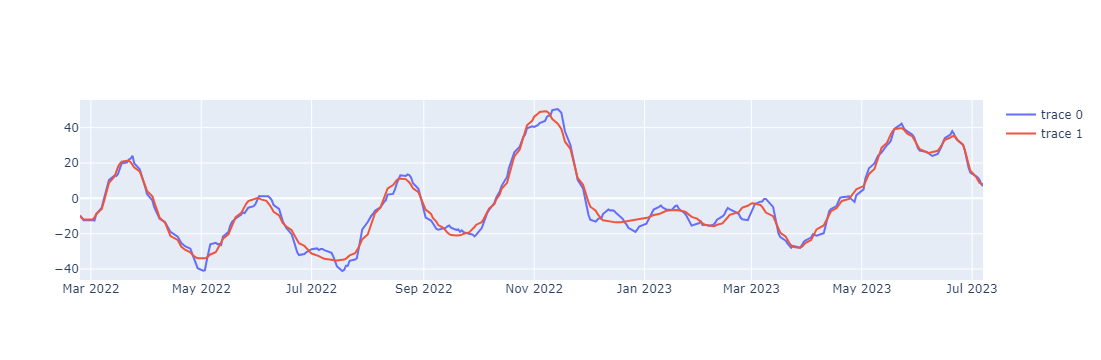

In [65]:
ativo_df_prev = preparar_dados_financeiros("KLBN11.SA",1,start="2022-01-01",end="2023-07-25",remove_out=False)

tsi_df_prev= GetTsi(ativo_df_prev, 80, 0.009)


fig = go.Figure()

fig.add_trace(go.Scatter(x=tsi_df_prev.index, y=tsi_df_prev["tsi"]))
fig.add_trace(go.Scatter(x=tsi_df_prev.index, y=tsi_df_prev["gaussian"]))

fig.show()

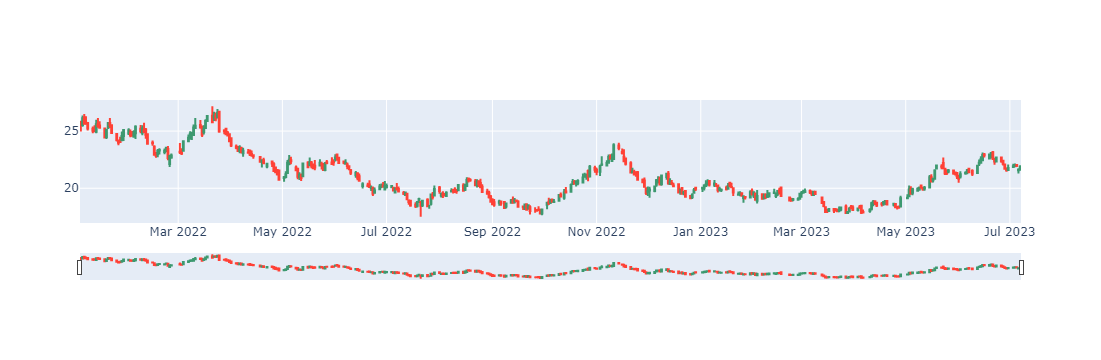

In [66]:
fig = go.Figure(data=[go.Candlestick(x=ativo_df_prev.index,
                open=ativo_df_prev['Open'],
                high=ativo_df_prev['High'],
                low=ativo_df_prev['Low'],
                close=ativo_df_prev['Close'])])

fig.show()